<a href="https://colab.research.google.com/github/Pengyu-gis/RemoteCLIP/blob/main/remoteclip_finetuning_test1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prepare Dataset and Environment



In [ ]:
!pip install huggingface_hub open_clip_torch
!git clone https://github.com/ChenDelong1999/RemoteCLIP/

In [2]:
# load dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title Load packages and download model weights
from huggingface_hub import hf_hub_download
import torch, open_clip
from PIL import Image
from IPython.display import display

# for model_name in ['RN50'] #, 'ViT-B-32', 'ViT-L-14']: #faster loading
for model_name in ['RN50', 'ViT-B-32', 'ViT-L-14']: #all models
    checkpoint_path = hf_hub_download("chendelong/RemoteCLIP", f"RemoteCLIP-{model_name}.pt", cache_dir='checkpoints')
    print(f'{model_name} is downloaded to {checkpoint_path}.')

In [4]:
# @title Select Model
model_name = 'RN50' # @param ['RN50', 'ViT-B-32', 'ViT-L-14']
model, _, preprocess = open_clip.create_model_and_transforms(model_name)
tokenizer = open_clip.get_tokenizer(model_name)

path_to_your_checkpoints = 'checkpoints/models--chendelong--RemoteCLIP/snapshots/bf1d8a3ccf2ddbf7c875705e46373bfe542bce38'

ckpt = torch.load(f"{path_to_your_checkpoints}/RemoteCLIP-{model_name}.pt", map_location="cpu")
message = model.load_state_dict(ckpt)
print(message)
model = model.cuda().eval()

<All keys matched successfully>


## 定义数据加载器


In [8]:
import os
import pandas as pd
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

class ImageTextDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        # self.img_labels = pd.read_csv(annotations_file)
        self.img_labels = pd.read_csv(annotations_file)

        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
      img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
      image = Image.open(img_path)
      image = image.convert('RGB')  # Convert to RGB
      caption = self.img_labels.iloc[idx, 1]
      if self.transform:
          image = self.transform(image)
      return image, caption


# data transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to the expected input size of the model
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize images
])


# creat dataset and dataloader
dataset = ImageTextDataset(annotations_file='/content/drive/MyDrive/my_clip/sea_clip_dataset/caption.csv',
                           img_dir='/content/drive/MyDrive/my_clip/sea_clip_dataset/images',
                           transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


Captions:
An satellite view of battleships, including cruisers, destroyers, and frigates, large in size and generally elongated in shape, in naval warfare contexts.
An satellite view of breeding ponds, featuring deep green water bodies with rectangular plots similar to cultivated fields, in aquaculture settings.
An satellite view of a reef, featuring brown-colored rocks very close to the water surface, surrounded by seawater, in marine ecosystems.
An satellite view of construction land, featuring artificially constructed buildings and surrounding areas designated for development, in urban or developing regions.
An satelite view of white aquaculture floats, featuring white speckled patches, fixed to the surface of the sea.
An satellite view of a crane at a port, involved in the loading and unloading of goods from ships and vehicles, stacking and destacking goods in yards, and handling cargo inside ships, train cars, and warehouses, in logistic and port areas.
An satellite view of an air

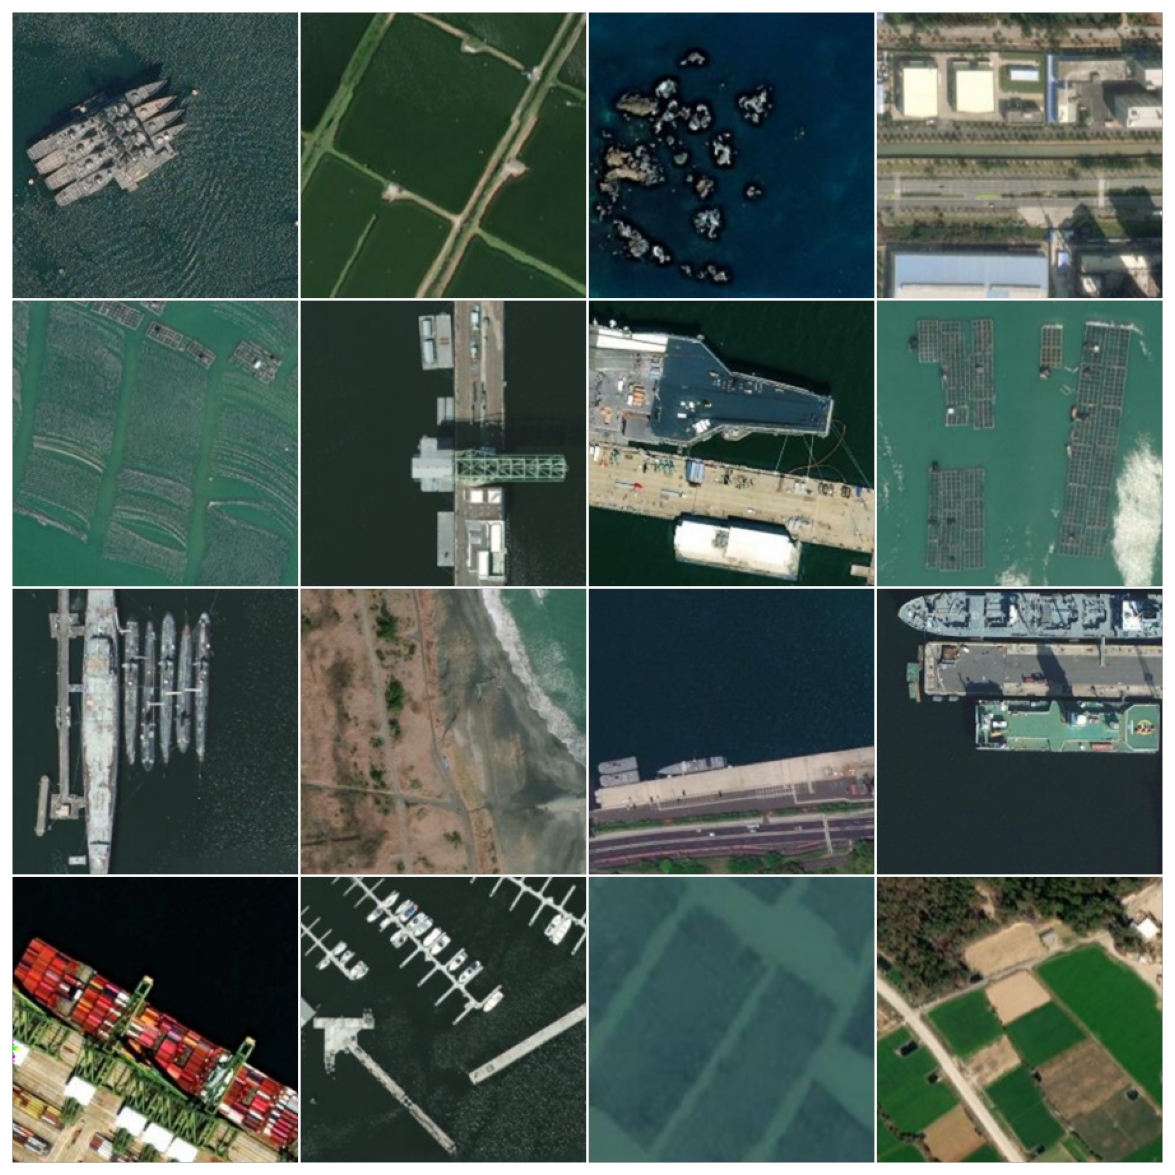

In [6]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def show_images_batch(sample_batch):
    """Visualizes a batch of images and prints their captions."""
    images, captions = sample_batch
    grid = make_grid(images, nrow=4)  # Adjust nrow to fit your batch size if necessary
    plt.figure(figsize=(15, 15))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    print('Captions:')
    for caption in captions:
        print(caption)

# Fetch a single batch from the DataLoader
batch = next(iter(dataloader))

# Visualize the batch
show_images_batch(batch)

# Fine-tuning the model
Once the data loader has been defined, fine-tuning the model can begin. This involves iterating the data loader, feeding each batch of images and text into the model, calculating the loss, and updating the model's weights. The following is a simplified example of the fine-tuning process.

In [10]:
from torch import nn, optim, from_numpy
import numpy as np
from open_clip import tokenize

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"

# If the model isn't automatically moved to the correct device, explicitly do so
model = model.to(device)


# 假设已经定义了optimizer和loss function
optimizer = optim.Adam(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()

num_epochs = 100  # Example number of epochs

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, captions) in enumerate(dataloader):
        images = images.to("cuda")
        text_tokens = tokenize(captions).to("cuda")  # Ensure captions are properly processed if needed

        # Zero the parameter gradients
        optimizer.zero_grad()
        # Temporarily capture the entire output
        output = model(images, text_tokens)

        image_features, text_features, _ = output

        # Example: Calculating a simple similarity-based loss
        similarity = torch.nn.functional.cosine_similarity(image_features, text_features, dim=1)

        # Compute loss
        # loss = criterion(image_features, text_features)  # Placeholder, adjust as necessary
        loss = 1 - similarity.mean()  # Aiming to maximize similarity

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 100 == 99:  # Print every 100 mini-batches
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100}")
            running_loss = 0.0

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(dataloader)}")


Epoch 1, Loss: 0.11409026384353638
Epoch 2, Loss: 0.38104772567749023
Epoch 3, Loss: 0.18853819370269775
Epoch 4, Loss: 0.11816179752349854
Epoch 5, Loss: 0.07036322355270386
Epoch 6, Loss: 0.04154759645462036
Epoch 7, Loss: 0.031087040901184082
Epoch 8, Loss: 0.027489542961120605
Epoch 9, Loss: 0.024337291717529297
Epoch 10, Loss: 0.02011573314666748
Epoch 11, Loss: 0.017461180686950684
Epoch 12, Loss: 0.015805184841156006
Epoch 13, Loss: 0.013427197933197021
Epoch 14, Loss: 0.011038482189178467
Epoch 15, Loss: 0.008989810943603516
Epoch 16, Loss: 0.007416248321533203
Epoch 17, Loss: 0.006467938423156738
Epoch 18, Loss: 0.005905508995056152
Epoch 19, Loss: 0.005494952201843262
Epoch 20, Loss: 0.005080461502075195
Epoch 21, Loss: 0.004675686359405518
Epoch 22, Loss: 0.004285275936126709
Epoch 23, Loss: 0.0038555264472961426
Epoch 24, Loss: 0.0033791065216064453
Epoch 25, Loss: 0.002877354621887207
Epoch 26, Loss: 0.0024247169494628906
Epoch 27, Loss: 0.0021044015884399414
Epoch 28, Los

In [11]:
# Save the model's state dictionary
torch.save(model.state_dict(), '/content/model_save/remoteclip_finetuning_state_dict.pth')

In [16]:
!cp /content/model_save/remoteclip_finetuning_state_dict.pth /content/drive/MyDrive/my_clip

## Test model for zero-shot

In [40]:
import torch
import open_clip

# Define the model architecture (should be the same as used for training)
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = 'RN50' # @param ['RN50', 'ViT-B-32', 'ViT-L-14']
model, _, preprocess = open_clip.create_model_and_transforms(model_name)
tokenizer = open_clip.get_tokenizer(model_name)
# model, preprocess = clip.load("ViT-B/32", device=device)  # Assuming you used ViT-B/32 for training
# model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')

# Load the state dictionary
model.load_state_dict(torch.load('/content/model_save/remoteclip_finetuning_state_dict.pth'))

# Move model to evaluation mode
model.eval()


CLIP(
  (visual): ModifiedResNet(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act2): ReLU(inplace=True)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act3): ReLU(inplace=True)
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (

In [21]:
from PIL import Image

# Load and preprocess an image
image_path = '/content/50013.tif'
image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)


In [22]:
if image.device != next(model.parameters()).device:
    model.to(image.device)

In [37]:
text_descriptions = ["An satellite view of cargo ship near a sea port.", "A broken mirror in the water", "A little cat playing a ball"]  # Example labels
text_tokens = open_clip.tokenize(text_descriptions).to(device)


In [38]:
with torch.no_grad():  # No gradients needed for inference
    # Forward pass
    image_features = model.encode_image(image)
    text_features = model.encode_text(text_tokens)

    # Calculate cosine similarities
    cosine_similarities = torch.nn.functional.cosine_similarity(image_features, text_features)

    # Softmax-normalize the similarities to get probabilities
    probabilities = torch.nn.functional.softmax(cosine_similarities, dim=0)

    # Get the most likely description index
    predicted_index = probabilities.argmax()

    # Print the most similar text description and its probability
    print(f"Predicted description: {text_descriptions[predicted_index]}")
    print(f"Confidence: {probabilities[predicted_index].item():.4f}")

    # Print all descriptions with their probabilities
    for i, (desc, prob) in enumerate(zip(text_descriptions, probabilities)):
        print(f"{desc}: {prob.item():.4f}")

Predicted description: An satellite view of cargo ship near a sea port.
Confidence: 0.3353
An satellite view of cargo ship near a sea port.: 0.3353
A broken mirror in the water: 0.3332
A little cat playing a ball: 0.3315
